# Convolutional Neural Networks 

## Background

The code in this notebook formed part of a coursework completed for the 'Deep Learning' course. It is written in PyTorch, and is split into different parts

A summary of the parts is as follows:
1. Part 1: define the 2D convolution, max pooling operation, linear layer and 2D batch normalization
2. Part 2: train a ResNet-18  on the CIFAR-10 dataset
3. Part 3: answers to questions

## Part 1 - Implement Conv2D, MaxPool2D, Linear layer, BatchNorm2D

#### 2D Convolution

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        # Define parameters
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias

        # Randomly initialise weights. Normalise using Kaiming: sqrt(2/fan_in)
        self.w = torch.randn(
            (self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
        nn.init.kaiming_uniform_(self.w, mode='fan_in', nonlinearity='relu')

        self.w.requires_grad = True

        # Initialise biases to small value (as using ReLu)
        self.b = torch.zeros((self.out_channels,))
        self.b[:] = 0.01
        self.b.requires_grad = True

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        # Initialise bias
        if self.bias:
            b = self.b
        else:
            b = 0
            
        # dimensions of input
        N = x.size(0)
        H = x.size(2)
        W = x.size(3)

        # output dimensions
        H_out = int(((H - self.kernel_size + 2*self.padding)/self.stride) + 1)
        W_out = int(((W - self.kernel_size + 2*self.padding)/self.stride) + 1)

        # Calculating Convolutions
        # unfold input to shape (N,C*num_elements_in_kernel (K),number_conv_blocks (L))
        unfolded_x = F.unfold(x, (self.kernel_size, self.kernel_size),
                              stride=self.stride, padding=self.padding)
        
        # Transpose input - unfolded_x_T dimensions: [N, L, K]
        unfolded_x_T = unfolded_x.transpose(1, 2)
        
        # Flatten kernel - flattened_w dimenions: [K,F] i.e 1 column per filter
        flattened_w = self.w.view(self.w.size(0), -1).t()

        # Apply matrix multiplication to evaluate dot products of all blocks + filters simultaneously
        # conv_mat dimensions: [N,L,F] [batch_size,number_conv_blocks,number_filters]
        # i.e each column corresponds to all the elements of a filtered image (1 column per filter)
        flattened_w = flattened_w.to()

        conv_mat = unfolded_x_T.matmul(flattened_w) + b

        # transpose to get each row = filtered image [N,F,L]
        conv_mat_T = conv_mat.transpose(1, 2)
        # reshape output to N,F,H',W'
        out = conv_mat_T.view(N, self.out_channels, H_out, W_out)

        return out

#### MaxPool 2D

In [6]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        # Assuming no padding and dilation = 1
        self.kernel_size = kernel_size

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C(F?), H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # dimensions of input
        N = x.size(0)
        C = x.size(1)
        H = x.size(2)
        W = x.size(3)

        # Assigning stride to kernel size by default
        stride = self.kernel_size

        # Assuming no padding, dilation =1

        H_out = int(((H - 1*(self.kernel_size[0]-1)-1)/stride[0]) + 1)
        W_out = int(((W - 1*(self.kernel_size[1]-1)-1)/stride[1]) + 1)

        unfolded_x_1 = F.unfold(
            x, (self.kernel_size[0], self.kernel_size[1]), stride=stride)
        
        unfolded_x_2 = unfolded_x_1.unfold(dimension=1,
                                           size=self.kernel_size[0] *
                                           self.kernel_size[1],
                                           step=self.kernel_size[0] *
                                           self.kernel_size[1]
                                           )

        unfolded_out = torch.max(unfolded_x_2, dim=3, keepdim=True)[0]
        out = unfolded_out.view((x.size(0), x.size(1), H_out, W_out))

        return out

#### Linear Layer

In [7]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # initialising parameters
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias = bias

        # Randomly initialise weights. Normalise using Kaiming: sqrt(2/fan_in)
        self.w = torch.randn((self.in_channels, self.out_channels))
        nn.init.kaiming_uniform_(self.w, mode='fan_in', nonlinearity='relu')

        # Initilaise bias to zero. Append to weights if True
        if self.bias:
            self.b = torch.zeros((out_channels,))
            W = torch.zeros((in_channels + 1, out_channels))
            W[:-1, :] = self.w
            W[-1, :] = self.b
            self.w = W

        self.w.requires_grad = True  # as learnable parameter

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """

        N = x.size(0)
        H = self.in_channels
        H_out = self.out_channels

        if len(x.size()) == 2:
            x = x.unsqueeze(1)

        if self.bias:
            X = torch.ones(N, x.size(1), H + 1)
            X[:, :, :-1] = x
            x = X

        out = torch.matmul(x, self.w)

        return out

#### 2D Batch Normalisation

In [8]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        # initialising parameters
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        
        # Initialise gamma to 1
        self.gamma = torch.ones(num_features)
        
        # Initialise beta to 0
        self.beta = torch.zeros(num_features)

        # Gamma and beta require gradients (as learnable)
        self.gamma.requires_grad = True
        self.beta.requires_grad = True

        self.running_mean = 0
        self.running_var = 0

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """

        if self.training:
            # taking mean over dimensions N,H,W --output of size (C) - 1 average val per channel
            # i.e mean channel value over minibatch
            mean = x.mean([0, 2, 3])
            
            # finding var over dimensions N,H,W
            var = x.var([0, 2, 3])
            n = x.numel() / x.size(1)

            with torch.no_grad():
                # update running mean - Eqn from pytorch documentation
                self.running_mean = (1-self.momentum) * \
                    self.running_mean + (self.momentum * mean)
                # update running var
                self.running_var = (
                    1-self.momentum)*self.running_var * (n/(n-1)) + (self.momentum * var)

        else:
            mean = self.running_mean
            var = self.running_Var

        # normalise data. 'Nones' get the mean tensor to the right size.
        # basically take the mean value of channel pixel values for whole batch off whole batch
        x = ((x - mean[None, :, None, None]) / torch.sqrt(var[None, :, None, None] +
                                                          self.eps))*self.gamma[None, :, None, None] + self.beta[None, :, None, None]

        return x

## Part 2 - Train a ResNet - 18


**Question**:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

**A**: Since the training set has a large number of data, it is uneccesarry to use any cross-validation techniques - a simple split into train, validation and test sets is sufficient. There are a large number of trainable parameters, so a random search, although relatively expensive, is a good method for hyperparemeter search. The paper by Bergstra, J., & Bengio, Y. (2012) shows that random search is significantly more efficient than a grid search. Furthermore, since there are a relatively large number of hyperparameters, a manual tuning would be inefficient. As such, in this part a random search is implemented to perform hyperparameter search.

In [5]:
import torch
from torch.nn import Conv2d, MaxPool2d  
import torch.nn as nn
import torch.nn.functional as F

Defining ResNet-18

In [6]:
# define resnet building blocks


class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock, self).__init__()

        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.LeakyReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel))

        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding=0, bias=False),
                                          nn.BatchNorm2d(outchannel))

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.leaky_relu(out)
        return out

    # define resnet


class ResNet(nn.Module):

    def __init__(self, ResidualBlock, num_classes=10):

        super(ResNet, self).__init__()

        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size=3, stride=1,
                                          padding=1, bias=False),
                                   nn.BatchNorm2d(64),
                                   nn.LeakyReLU())

        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.maxpool = MaxPool2d(4)

        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)

        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset


In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T


# Data augmentation
transform_train = T.Compose([T.RandomCrop(32),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize((0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010))
                             ])

# Normalising input
transform_test_val = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

Making dataloaders

In [ ]:
# hyper parameters
batch_size = 64

NUM_TRAIN = 49000

data_dir = './data'

# Train dataloader
cifar10_train = dset.CIFAR10(data_dir, train=True, download=True,
                             transform=transform_train)

loader_train = DataLoader(cifar10_train, batch_size=batch_size,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))


# Validation dataloader
cifar10_val = dset.CIFAR10(data_dir, train=True, download=True,
                           transform=transform_test_val)

loader_val = DataLoader(cifar10_val, batch_size=batch_size,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

# Test dataloader
cifar10_test = dset.CIFAR10(data_dir, train=False, download=True,
                            transform=transform_test_val)

loader_test = DataLoader(cifar10_test, batch_size=batch_size)

#### Training Loop

In [9]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

print_every = 1000


def check_accuracy(loader, model):
    # function for test accuracy on validation and test set

    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
        
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' %
              (num_correct, num_samples, 100 * acc))
        return acc


def train_part(model, optimizer, loader_train, epochs=1, scheduler=None):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    
    train_loss = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            
            # move to device, e.g. GPU
            x = x.to(device=device, dtype=dtype) 
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' %
                      (e, t, loss.item()))
#                 check_accuracy(loader_val, model)
                print()
        
        train_loss.append(loss.item())

        # Adjust the learning rate
        if scheduler is not None:
            scheduler.step()
    return train_loss 

using device: cuda


#### Hyperparameter selection

List of hyperparameters:
- lr
- epochs
- weight_decay
- lr decay gamma

List of things I implemented:
- Leaky ReLu instead of ReLu (to encourage gradient flow)
- Data augmentation (RandomCrop and RandomHorizontalFlip)
- Learning rate decay scheduler


I used random search to narrow down hyperparameter space. The paper by Bergstra, J., & Bengio, Y. (2012) shows that random search is much more efficient than grid search.
Hyper parameter ranges were selected by experimentation.

The model that had the highest validation accuracy was selected

In [12]:
# code for optimising network performance

import numpy as np

num_configs = 30

# Hyper parameters
epochs = [9, 10]
lrs = [5e-4, 1e-3, 3e-3, 5e-3, 1e-2]  # +- 1 order of magnitude
weight_decays = [0.0005, 0.001, 0.005, 0.01]  # +- 1 order of magnitude
gammas = [0.25, 0.05, 0.1, 0.5]

storage = dict()

for i in range(num_configs):
    model = ResNet18()
    lr = np.random.choice(lrs)
    epoch = np.random.choice(epochs)
    gamma = np.random.choice(gammas)
    weight_decay = np.random.choice(weight_decays)

    print(
        f"Batch Size: {batch_size}, Epochs: {epoch}, LR: {lr}, weight decay: {weight_decay}")
    model_type = f"{batch_size}_{epoch}_{lr}_{weight_decay}"

    optimizer = optim.Adam(model.parameters(), lr=lr,
                           weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=gamma)
    train_loss = train_part(model, optimizer, loader_train,
                            epochs=epoch, scheduler=scheduler)

    valid_acc = check_accuracy(loader_val, model)

    data = {model_type: {'valid_acc': valid_acc, 'train_loss': train_loss}}
    storage.update(data)
    torch.save(model.state_dict(), f'model_{model_type}.pt')

Batch Size: 64, Epochs: 9, LR: 0.0005, weight decay: 0.005
766
Epoch: 0, Iteration 0, loss = 3.2580

766
Epoch: 1, Iteration 0, loss = 0.7979

766
Epoch: 2, Iteration 0, loss = 0.5608

766
Epoch: 3, Iteration 0, loss = 0.2026

766
Epoch: 4, Iteration 0, loss = 0.3819

766
Epoch: 5, Iteration 0, loss = 0.3432

766
Epoch: 6, Iteration 0, loss = 0.4293

766
Epoch: 7, Iteration 0, loss = 0.2386

766
Epoch: 8, Iteration 0, loss = 0.1941

Checking accuracy on validation set
Got 871 / 1000 correct (87.10)
Batch Size: 64, Epochs: 9, LR: 0.001, weight decay: 0.005
766
Epoch: 0, Iteration 0, loss = 3.3347

766
Epoch: 1, Iteration 0, loss = 0.9075

766
Epoch: 2, Iteration 0, loss = 0.6690

766
Epoch: 3, Iteration 0, loss = 0.4442

766
Epoch: 4, Iteration 0, loss = 0.3628

766
Epoch: 5, Iteration 0, loss = 0.3701

766
Epoch: 6, Iteration 0, loss = 0.3638

766
Epoch: 7, Iteration 0, loss = 0.2034

766
Epoch: 8, Iteration 0, loss = 0.3570

Checking accuracy on validation set
Got 866 / 1000 correct (

766
Epoch: 8, Iteration 0, loss = 1.0726

766
Epoch: 9, Iteration 0, loss = 1.1683

Checking accuracy on validation set
Got 573 / 1000 correct (57.30)
Batch Size: 64, Epochs: 10, LR: 0.0005, weight decay: 0.0005
766
Epoch: 0, Iteration 0, loss = 3.8389

766
Epoch: 1, Iteration 0, loss = 0.7361

766
Epoch: 2, Iteration 0, loss = 0.6091

766
Epoch: 3, Iteration 0, loss = 0.7843

766
Epoch: 4, Iteration 0, loss = 0.6056

766
Epoch: 5, Iteration 0, loss = 0.6528

766
Epoch: 6, Iteration 0, loss = 0.4283

766
Epoch: 7, Iteration 0, loss = 0.7046

766
Epoch: 8, Iteration 0, loss = 0.6993

766
Epoch: 9, Iteration 0, loss = 0.6521

Checking accuracy on validation set
Got 788 / 1000 correct (78.80)
Batch Size: 64, Epochs: 9, LR: 0.0005, weight decay: 0.005
766
Epoch: 0, Iteration 0, loss = 2.9200

766
Epoch: 1, Iteration 0, loss = 1.1756

766
Epoch: 2, Iteration 0, loss = 0.6125

766
Epoch: 3, Iteration 0, loss = 0.4567

766
Epoch: 4, Iteration 0, loss = 0.4082

766
Epoch: 5, Iteration 0, loss 

KeyboardInterrupt: 

In [16]:
################################################################################################
# Selecting the model with the largest validation set accuracy
##############################################################################################

# Loading model
model = ResNet18()
model.to(device)
path_to_file = "./model_64_9_0.0005_0.01.pt"

state_dict = torch.load(
    path_to_file,
    map_location=lambda storage, loc: storage.cuda('cuda'),
)

model.load_state_dict(state_dict)

# Test set accuracy
test = check_accuracy(loader_test, model)

Checking accuracy on test set
Got 8901 / 10000 correct (89.01)


## Part 3 - Answer Questions

***Questions reference feature maps below***
1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**Answers**

**A1**: Low-level (e.g. layer 1) feature maps are larger in size than high-level(e.g. layer 4) feature maps. Furthermore, the level of abstraction increases from low-level layers to high-level layers, as important features of the image is represented in a more abstract, yet concise, manner. Earlier layers contain most of the information in the raw image, and commonly act as edge detectors. Important features are not clearly highlighted, and there is significant noise in the feature maps. Feature maps in high-level layers, while smaller in size, become sparser and highlight important features about the class of image (rather than the image itself). This explains why CNNs generalise well on image classification tasks.

The number of feature maps is much greater in higher levels, with each feature map representing a specific important feature in the image. In lower levels, with fewer feature maps, each feature map is trying to 'represent too much information', which results many features being detected. As we go deeper into the network, the feature maps become sparser and start to represent more complex features.


**A2**: The cell immediately below shows the training log for my model. It is observed that training loss generally decreased with the number of epochs. This is to be expected as the model's weights are updated during training to minimise the loss function. Furthermore, the validation accuracy was evaluated after training. The validation accuracy was used to determine the optimal hyper parameters. It is observed that the model achieved a high validation accuracy. The model was then evaluated on the test set, where it achieved a comparable accuracy to the validation accuracy (89.7% validation compared with 89.01% test). This implies that the model performs well on unseen data, and there is little overfitting. Furthermore, on observing the later stage feature maps, it can be seen that each feature map represents a clearly defined feature of the image. This is 'nice' for the  final fully connected classification layer and helps to explain the relatively high performance of the model. 

**A3**: Performance of the network can be analysed by the time taken both to train, and to run inference. A higher performing network would be able to achieve similar classification accuracies in a shorter time. 

Furthermore, different performance metrics could be used such as Precision, Recall or an F-score. The choice of metric is dependent on application - for example in medical applications Recall is considered a very important metric, as it limits the number of false negatives. An F-score (e.g. F-1) is a good compromise as it is a combination of precision and recall. Moreover, the Akaike information criterion (AIC) could be used as an estimation of prediction error.



![conv1](conv1.jpg)
![layer1](layer1.jpg)
![layer2](layer2.jpg)
![layer3](layer3.jpg)
![layer4](layer4.jpg)

<Figure size 432x288 with 0 Axes>

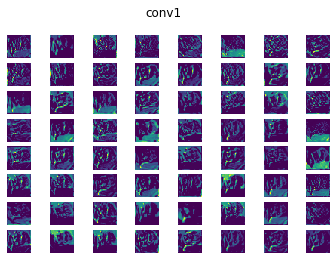

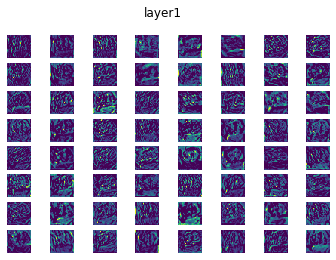

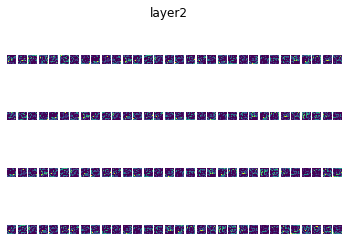

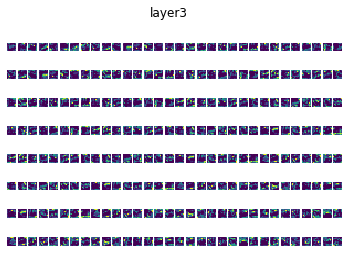

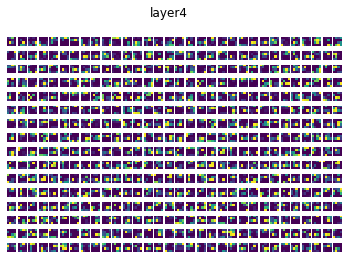

In [18]:
import matplotlib.pyplot as plt

plt.tight_layout()

activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))


data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device=device, dtype=dtype)

output = model(data)

for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32

    nrows = act.size(0) // ncols

    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)

    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')